# BMW Car Sales — Data Preparation & EDA
### INFO-523 Final Project | Min Set Khant (Solo)
#### This notebook performs: data audit, cleaning, feature engineering, EDA, temporal-split checks,and saves cleaned/processed datasets + key visuals for the dashboard.

In [1]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")
%matplotlib inline
# Load the Data and Set Paths
DATA_PATH = "../data/bmw_worldwide_sales.csv"   
OUTPUT_DIR = "../data/cleaned"                  
VISUALS_DIR = "../visuals"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(VISUALS_DIR, exist_ok=True)


In [2]:
# load the data file and quick overview of the dataset
df = pd.read_csv(DATA_PATH)
print("Raw shape:", df.shape)
display(df.head(10))
print("\nInfo:")
display(df.info())
print("\nNumeric summary (selected):")
display(df.describe().T)
print("\nCategorical summary (selected):")
display(df.describe(include='object').T)

Raw shape: (50000, 11)


,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low
5,5 Series,2017,Middle East,Silver,Diesel,Manual,1.9,171362,42926,1232,Low
6,i8,2022,Europe,White,Diesel,Manual,1.8,196741,55064,7949,High
7,M5,2014,Asia,Black,Diesel,Automatic,1.6,121156,102778,632,Low
8,X3,2016,South America,White,Diesel,Automatic,1.7,48073,116482,8944,High
9,i8,2019,Europe,White,Electric,Manual,3.0,35700,96257,4411,Low



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model                 50000 non-null  object 
 1   Year                  50000 non-null  int64  
 2   Region                50000 non-null  object 
 3   Color                 50000 non-null  object 
 4   Fuel_Type             50000 non-null  object 
 5   Transmission          50000 non-null  object 
 6   Engine_Size_L         50000 non-null  float64
 7   Mileage_KM            50000 non-null  int64  
 8   Price_USD             50000 non-null  int64  
 9   Sales_Volume          50000 non-null  int64  
 10  Sales_Classification  50000 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 4.2+ MB


None


Numeric summary (selected):


,count,mean,std,min,25%,50%,75%,max
Year,50000.0,2017.01570,4.324459,2010.0,2013.00,2017.0,2021.00,2024.0
Engine_Size_L,50000.0,3.24718,1.009078,1.5,2.40,3.2,4.10,5.0
Mileage_KM,50000.0,100307.20314,57941.509344,3.0,50178.00,100388.5,150630.25,199996.0
Price_USD,50000.0,75034.60090,25998.248882,30000.0,52434.75,75011.5,97628.25,119998.0
Sales_Volume,50000.0,5067.51468,2856.767125,100.0,2588.00,5087.0,7537.25,9999.0



Categorical summary (selected):


,count,unique,top,freq
Model,50000,11,7 Series,4666
Region,50000,6,Asia,8454
Color,50000,6,Red,8463
Fuel_Type,50000,4,Hybrid,12716
Transmission,50000,2,Manual,25154
Sales_Classification,50000,2,Low,34754


In [3]:
# Initial data audit: missing, duplicates, types, unique counts
print("Missing values by column:\n", df.isna().sum())
print("\nDuplicate rows:", df.duplicated().sum())
for c in ['Model','Region','Color','Fuel_Type','Transmission','Sales_Classification']:
    print(f"\n-- Unique sample for {c} (n={df[c].nunique()}):")
    print(df[c].value_counts().head(8))

Missing values by column:
 Model                   0
Year                    0
Region                  0
Color                   0
Fuel_Type               0
Transmission            0
Engine_Size_L           0
Mileage_KM              0
Price_USD               0
Sales_Volume            0
Sales_Classification    0
dtype: int64

Duplicate rows: 0

-- Unique sample for Model (n=11):
Model
7 Series    4666
i3          4618
i8          4606
3 Series    4595
5 Series    4592
X1          4570
X3          4497
X5          4487
Name: count, dtype: int64

-- Unique sample for Region (n=6):
Region
Asia             8454
Middle East      8373
North America    8335
Europe           8334
Africa           8253
South America    8251
Name: count, dtype: int64

-- Unique sample for Color (n=6):
Color
Red       8463
Silver    8350
Grey      8348
White     8304
Black     8273
Blue      8262
Name: count, dtype: int64

-- Unique sample for Fuel_Type (n=4):
Fuel_Type
Hybrid      12716
Petrol      12550
Electric

In [4]:
# Copy and normalize (cleaning start)
df_raw = df.copy() 
# Normalize column names (strip)
df.columns = [c.strip() for c in df.columns]
# Standardize common string columns
str_cols = ["Model","Region","Color","Fuel_Type","Transmission","Sales_Classification"]
for c in str_cols:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().replace({'nan': np.nan})
        df[c] = df[c].str.title()   # Title case for consistent display

In [5]:
# Fix numeric types & simple conversions
num_cols = ["Year","Engine_Size_L","Mileage_KM","Price_USD","Sales_Volume"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Quick check
display(df[num_cols].head())
print(df[num_cols].isna().sum())

,Year,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume
0,2016,3.5,151748,98740,8300
1,2013,1.6,121671,79219,3428
2,2022,4.5,10991,113265,6994
3,2024,1.7,27255,60971,4047
4,2020,2.1,122131,49898,3080


Year             0
Engine_Size_L    0
Mileage_KM       0
Price_USD        0
Sales_Volume     0
dtype: int64


In [6]:
#  Derived features
CURRENT_YEAR = 2025
df["Car_Age"] = CURRENT_YEAR - df["Year"]
df["Log_Price_USD"] = np.log1p(df["Price_USD"])
df["Price_per_KM"] = df["Price_USD"] / df["Mileage_KM"].replace(0, np.nan)
df["Price_per_KM"] = df["Price_per_KM"].fillna(df["Price_per_KM"].median())

In [7]:
# Transmission normalization & fuel check
# Normalize common variants
df["Transmission"] = df["Transmission"].replace({
    "Auto": "Automatic",
    "Man": "Manual",
    "Automated Manual": "Automatic"
}).fillna("Unknown")

# If there are one-hot fuel columns (rare), combine them
fuel_onehot = set(["Fuel_Type_Petrol","Fuel_Type_Hybrid","Fuel_Type_Electric"]).intersection(df.columns)
if fuel_onehot:
    df["Fuel_Type"] = np.select(
        [df.get("Fuel_Type_Petrol")==1, df.get("Fuel_Type_Hybrid")==1, df.get("Fuel_Type_Electric")==1],
        ["Petrol","Hybrid","Electric"],
        default=df["Fuel_Type"].fillna("Other")
    )
df["Fuel_Type"] = df["Fuel_Type"].fillna("Other")

In [8]:
# Missing values & duplicates handling (documented decisions)
# Decision rules (document in notebook markdown):
# - No rows dropped unless Price_USD missing (target).
# - Engine_Size_L: impute median per Model, otherwise global median.
# - Year, Mileage, Sales_Volume, Price: keep rows (dataset is complete).
# - Duplicates: if exact duplicates, drop them.

print("Duplicates before:", df.duplicated().sum())
df = df.drop_duplicates()
print("Duplicates after:", df.duplicated().sum())

# Impute Engine_Size_L per Model, fallback to global median
if "Engine_Size_L" in df.columns and "Model" in df.columns:
    df["Engine_Size_L"] = df.groupby("Model")["Engine_Size_L"].transform(lambda x: x.fillna(x.median()))
df["Engine_Size_L"] = df["Engine_Size_L"].fillna(df["Engine_Size_L"].median())

# Drop rows missing Price_USD (target)
before = df.shape[0]
df = df[~df["Price_USD"].isna()].copy()
after = df.shape[0]
print(f"Dropped {before-after} rows with missing Price_USD.")

Duplicates before: 0
Duplicates after: 0
Dropped 0 rows with missing Price_USD.


In [9]:
#  Outlier check (visual + IQR summary). 
from scipy import stats

def iqr_bounds(s, k=1.5):
    q1, q3 = np.nanpercentile(s, [25,75])
    iqr = q3 - q1
    return q1 - k*iqr, q3 + k*iqr

for c in ["Price_USD","Mileage_KM","Engine_Size_L","Sales_Volume"]:
    if c in df.columns:
        low, high = iqr_bounds(df[c].dropna(), k=1.5)
        pct_out = ((df[c] < low) | (df[c] > high)).mean() * 100
        print(f"{c}: IQR bounds [{low:.2f}, {high:.2f}], outliers ~ {pct_out:.3f}%")

Price_USD: IQR bounds [-15355.50, 165418.50], outliers ~ 0.000%
Mileage_KM: IQR bounds [-100500.38, 301308.62], outliers ~ 0.000%
Engine_Size_L: IQR bounds [-0.15, 6.65], outliers ~ 0.000%
Sales_Volume: IQR bounds [-4835.88, 14961.12], outliers ~ 0.000%


In [11]:
#  Feature engineering (bins and popularity)
# Engine size bins
df["Engine_Bin"] = pd.cut(df["Engine_Size_L"], bins=[0,1.6,2.0,3.0,4.0,10],
                          labels=["<=1.6","1.7-2.0","2.1-3.0","3.1-4.0",">4.0"])
# Age bins
df["Age_Bin"] = pd.cut(df["Car_Age"], bins=[-1,1,3,6,10,100], labels=["0-1","2-3","4-6","7-10","10+"])
# Model popularity
model_sales = df.groupby("Model")["Sales_Volume"].sum().rename("Total_Sales_Model").reset_index()
df = df.merge(model_sales, on="Model", how="left")

In [12]:
# Save an cleaned CSV 
clean_path = Path(OUTPUT_DIR) / "bmw_cleaned.csv"
df.to_csv(clean_path, index=False)
print("Saved cleaned CSV to:", clean_path)


Saved cleaned CSV to: ../data/cleaned/bmw_cleaned.csv


## Exploratory Visualizations

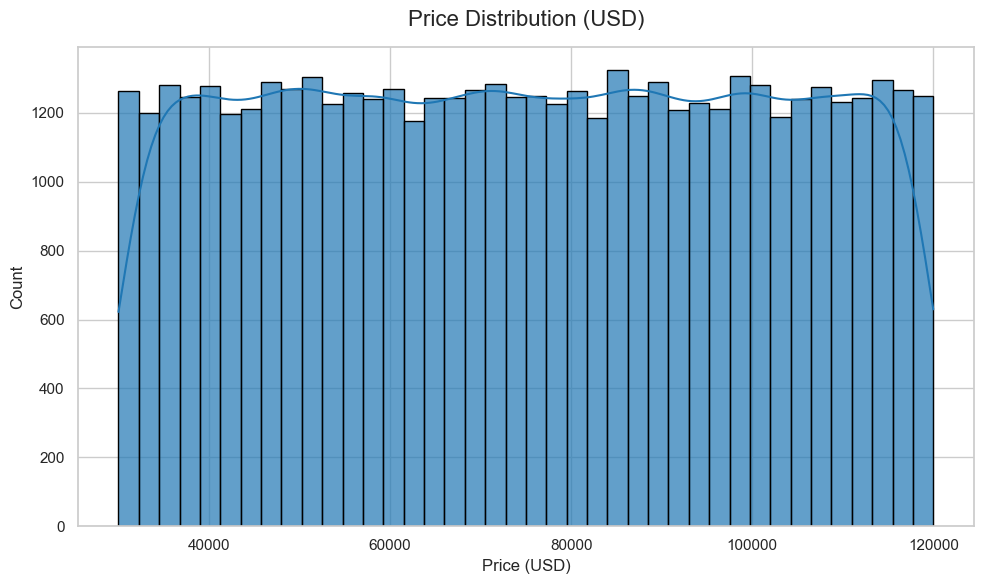

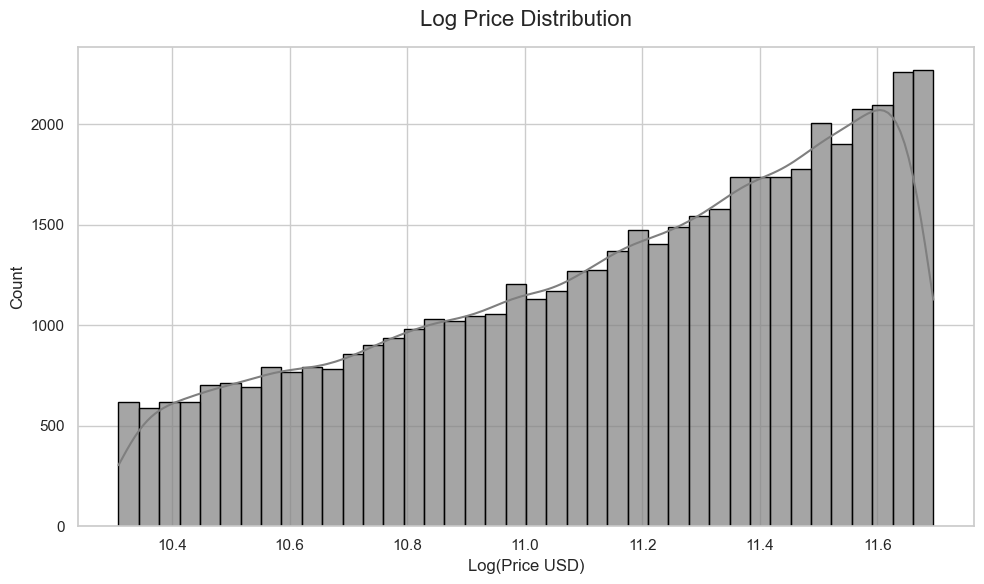

In [14]:
# EDA price distribution (linear and log)
plt.figure(figsize=(10, 6))
sns.histplot(
    df['Price_USD'],
    bins=40,
    kde=True,
    color='#1f77b4',  
    edgecolor='black',
    alpha=0.7
)
plt.title("Price Distribution (USD)", fontsize=16, pad=15)
plt.xlabel("Price (USD)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.savefig(Path(VISUALS_DIR)/"price_distribution.png", dpi=150)
plt.show()

# Log Price Distribution 
plt.figure(figsize=(10, 6))
sns.histplot(
    df['Log_Price_USD'],
    bins=40,
    kde=True,
    color='#7f7f7f',   
    edgecolor='black',
    alpha=0.7
)
plt.title("Log Price Distribution", fontsize=16, pad=15)
plt.xlabel("Log(Price USD)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.savefig(Path(VISUALS_DIR)/"log_price_distribution.png", dpi=150)
plt.show()


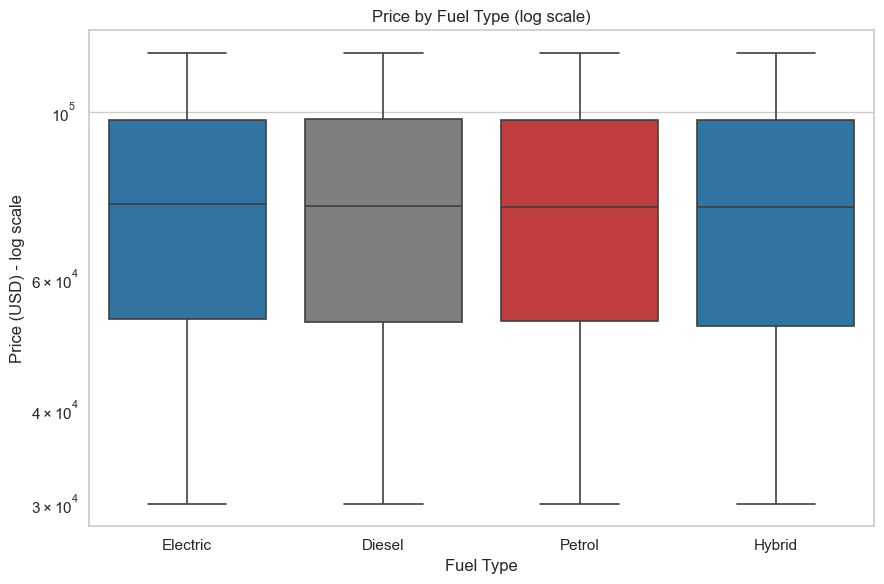

In [15]:
# EDA: Price by Fuel Type (boxplot, log y-scale for better readability)
plt.figure(figsize=(9,6))
order = df.groupby("Fuel_Type")["Price_USD"].median().sort_values(ascending=False).index
sns.boxplot(data=df, x="Fuel_Type", y="Price_USD", order=order, palette=['#1f77b4', '#7f7f7f', '#d62728'], 
    fliersize=5,   
    linewidth=1.2
)
plt.yscale("log")
plt.title("Price by Fuel Type (log scale)")
plt.xlabel("Fuel Type")
plt.ylabel("Price (USD) - log scale")
plt.tight_layout()
plt.savefig(Path(VISUALS_DIR)/"price_by_fueltype_box.png", dpi=150)
plt.show()

<Figure size 1200x600 with 0 Axes>

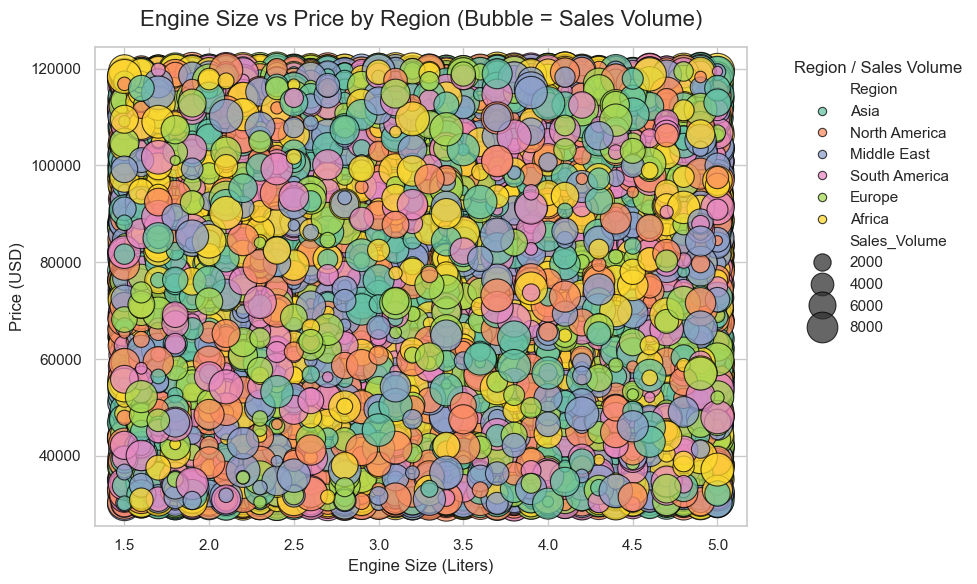

In [16]:
# Engine Size vs Price (bubble by Sales Volume)
plt.figure(figsize=(12,6))
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='Engine_Size_L',
    y='Price_USD',
    hue='Region',
    size='Sales_Volume',
    sizes=(50, 600),
    alpha=0.75,
    edgecolor='black',
    linewidth=0.8,
    palette='Set2'  
)
plt.title("Engine Size vs Price by Region (Bubble = Sales Volume)", fontsize=16, pad=15)
plt.xlabel("Engine Size (Liters)", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.legend(
    title="Region / Sales Volume",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=False
)
plt.tight_layout()
plt.savefig(Path(VISUALS_DIR)/"engine_vs_price_bubble.png", dpi=150)
plt.show()

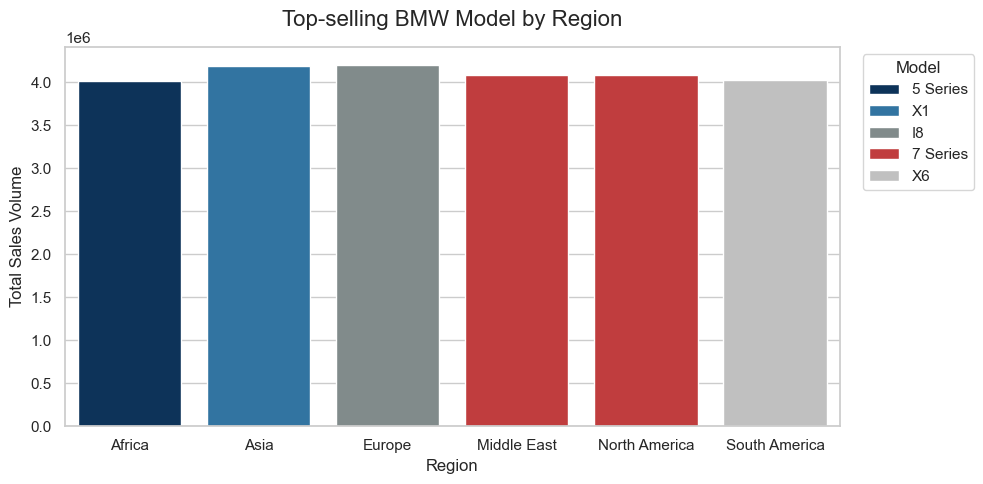

In [17]:
# EDA: Top-selling models per region (bar)
region_model_sales = df.groupby(["Region","Model"])["Sales_Volume"].sum().reset_index()
top_model_per_region = region_model_sales.loc[region_model_sales.groupby("Region")["Sales_Volume"].idxmax()]

plt.figure(figsize=(10,5))
sns.barplot(data=top_model_per_region, x="Region", y="Sales_Volume", hue="Model", dodge=False,
            palette=['#003366', '#1f77b4', '#7f8c8d', '#d62728', '#c0c0c0']  )
plt.title("Top-selling BMW Model by Region",fontsize=16, pad=15)
plt.xlabel("Region")
plt.ylabel("Total Sales Volume")
plt.legend(title="Model", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.savefig(Path(VISUALS_DIR)/"top_model_per_region.png", dpi=150)
plt.show()

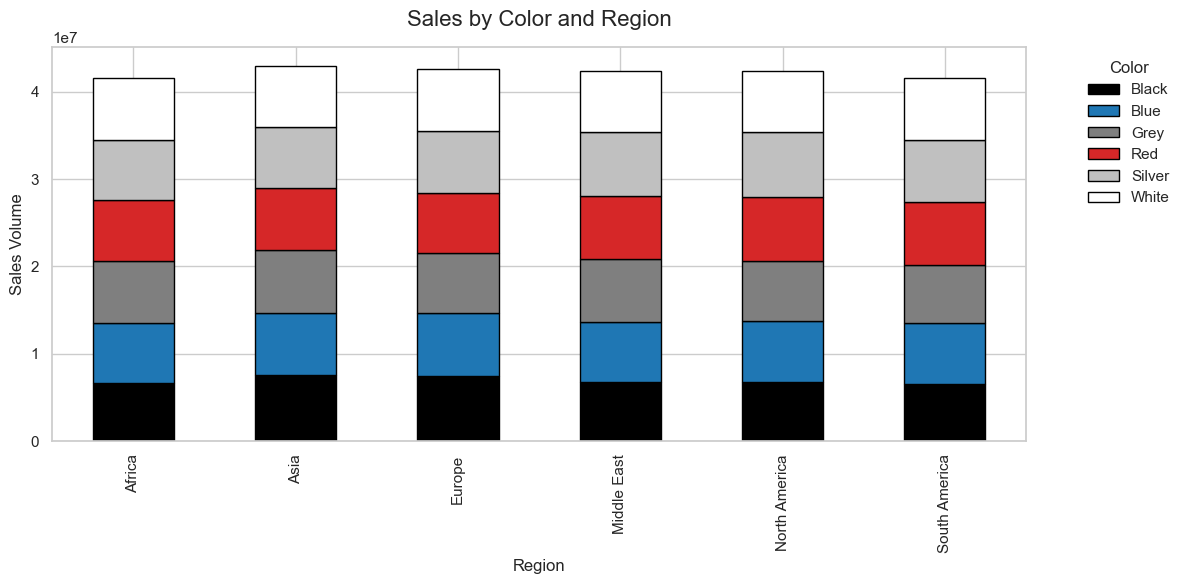

In [18]:
# Sales by Color and Region
# Create the pivot table
pivot_color = (
    df.groupby(['Region', 'Color'])['Sales_Volume']
      .sum()
      .unstack()
      .fillna(0)
)
# Plot
pivot_color.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=['#000000', '#1f77b4', '#7f7f7f', '#d62728', '#c0c0c0', '#ffffff'],
    edgecolor='black'
)

plt.title("Sales by Color and Region", fontsize=16, pad=15)
plt.ylabel("Sales Volume", fontsize=12)
plt.xlabel("Region", fontsize=12)
plt.legend(title="Color", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.savefig(Path(VISUALS_DIR)/"sales_by_color_region.png", dpi=150)
plt.show()

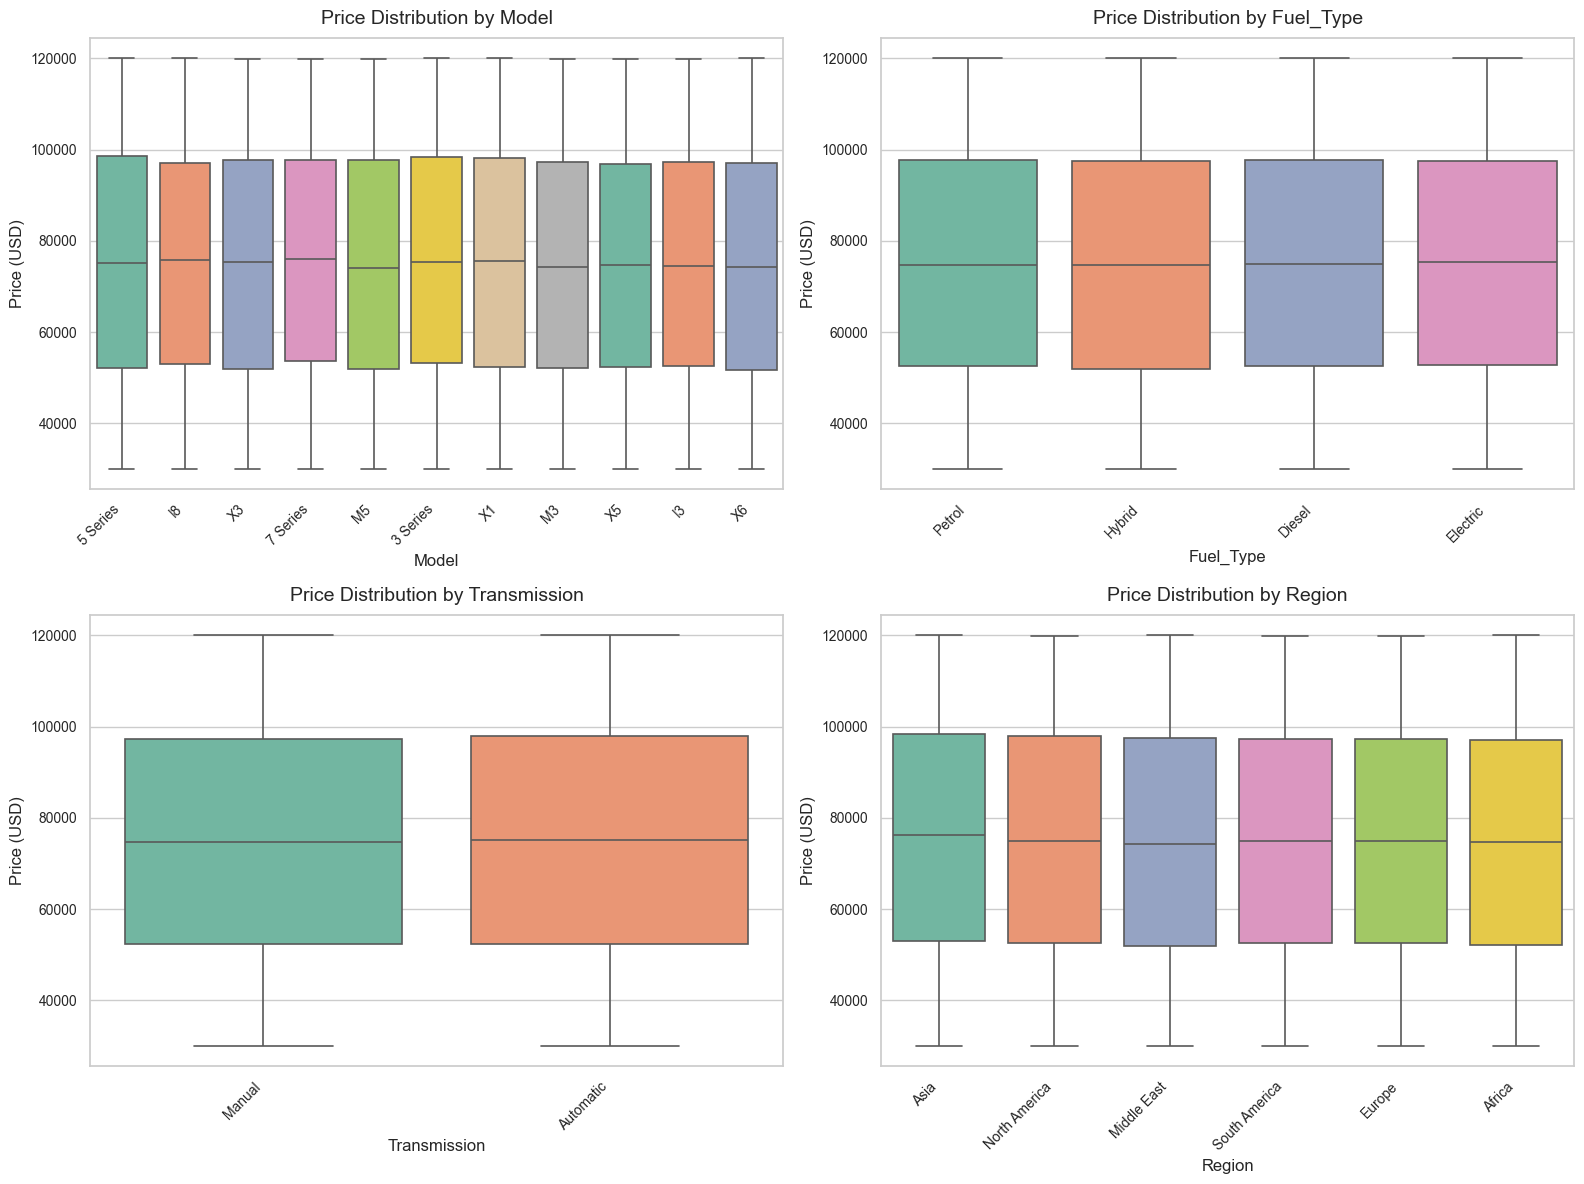

In [19]:
# Price Relationships by Feature
# Categorical features for boxplots 
cat_features = ['Model', 'Fuel_Type', 'Transmission', 'Region']

plt.figure(figsize=(16, 12))
sns.set_style("whitegrid")
palette = sns.color_palette("Set2")  

for i, col in enumerate(cat_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(
        x=col,
        y='Price_USD',
        data=df,
        palette=palette,
        fliersize=5,
        linewidth=1.2
    )
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(f'Price Distribution by {col}', fontsize=14, pad=10)
    plt.ylabel("Price (USD)", fontsize=12)
    plt.xlabel(col, fontsize=12)

plt.tight_layout()
plt.savefig(Path(VISUALS_DIR)/"price_by_categories_grid.png", dpi=150)
plt.show()

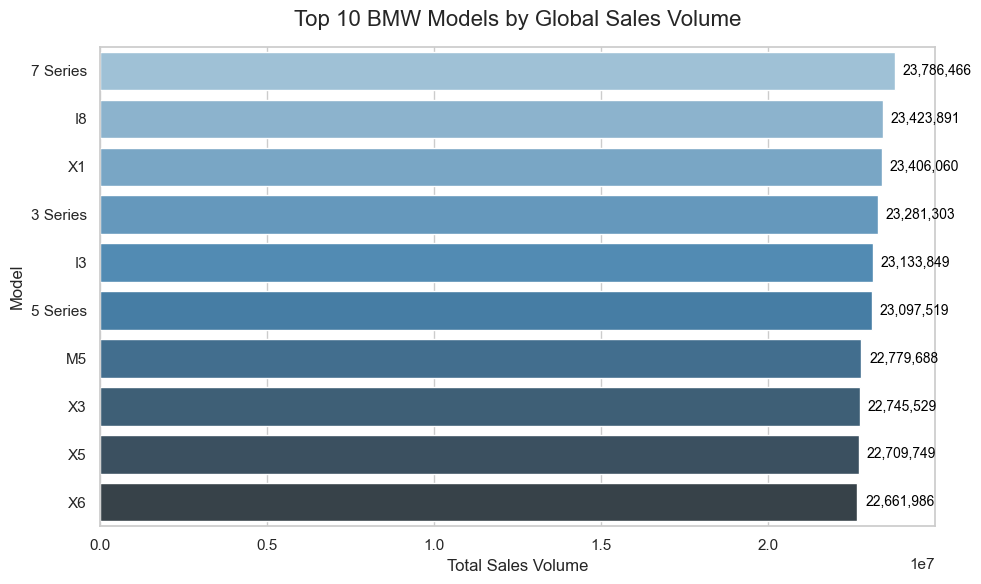

In [20]:
#  Top 10 models by global sales (horizontal bar)
top_models = df.groupby('Model')['Sales_Volume'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
palette = sns.color_palette("Blues_d", n_colors=10)  

barplot = sns.barplot(
    x=top_models.values,
    y=top_models.index,
    palette=palette
)
for i, v in enumerate(top_models.values):
    barplot.text(v + max(top_models.values)*0.01, i, f"{v:,}", color='black', va='center', fontsize=10)

plt.title("Top 10 BMW Models by Global Sales Volume", fontsize=16, pad=15)
plt.xlabel("Total Sales Volume", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.tight_layout()
plt.savefig(Path(VISUALS_DIR)/"top10_models_global.png", dpi=150)
plt.show()

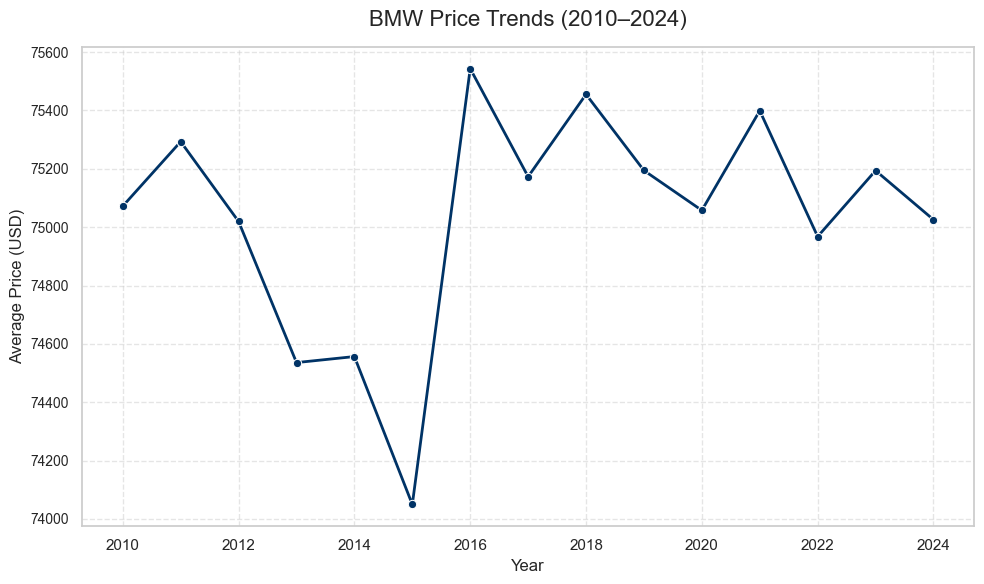

In [21]:
# Average Price Trend by Year 
yearly_avg = df.groupby('Year')['Price_USD'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.lineplot(
    x='Year',
    y='Price_USD',
    data=yearly_avg,
    marker='o',
    color='#003366', 
    linewidth=2.0
)
plt.title("BMW Price Trends (2010–2024)", fontsize=16, pad=15)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Price (USD)", fontsize=12)
plt.xticks(rotation=0)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(Path(VISUALS_DIR)/"avg_price_by_year.png", dpi=150)
plt.show()

Train shape (<=2020): (36504, 18)
Test shape (>2020): (13496, 18)


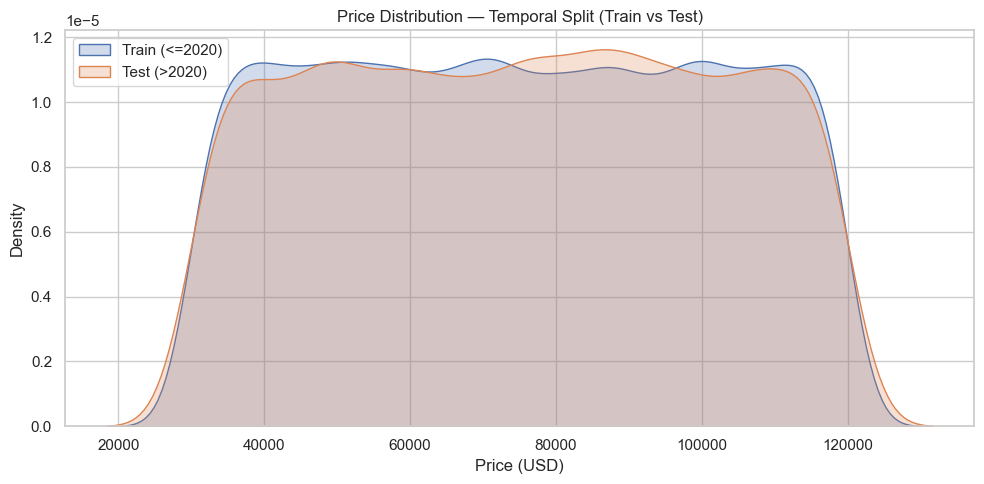

In [22]:
# Temporal split visualization (train <= 2020, test > 2020) for trend emulation
train_df = df[df["Year"] <= 2020].copy()
test_df = df[df["Year"] > 2020].copy()

print("Train shape (<=2020):", train_df.shape)
print("Test shape (>2020):", test_df.shape)

plt.figure(figsize=(10,5))
sns.kdeplot(train_df["Price_USD"], label="Train (<=2020)", fill=True)
sns.kdeplot(test_df["Price_USD"], label="Test (>2020)", fill=True)
plt.title("Price Distribution — Temporal Split (Train vs Test)")
plt.xlabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.savefig(Path(VISUALS_DIR)/"temporal_price_distribution.png", dpi=150)
plt.show()

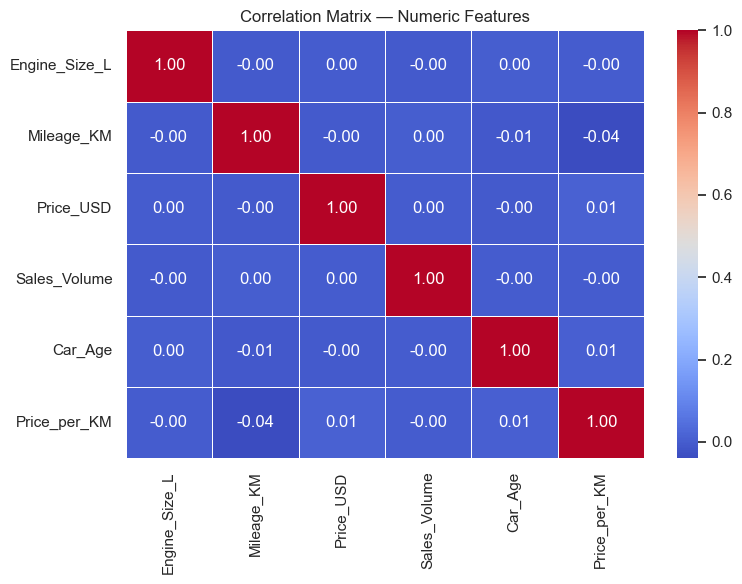

In [23]:
# Correlation heatmap for numeric features
num_cols = ["Engine_Size_L","Mileage_KM","Price_USD","Sales_Volume","Car_Age","Price_per_KM"]
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix — Numeric Features")
plt.tight_layout()
plt.savefig(Path(VISUALS_DIR)/"correlation_matrix.png", dpi=150)
plt.show()

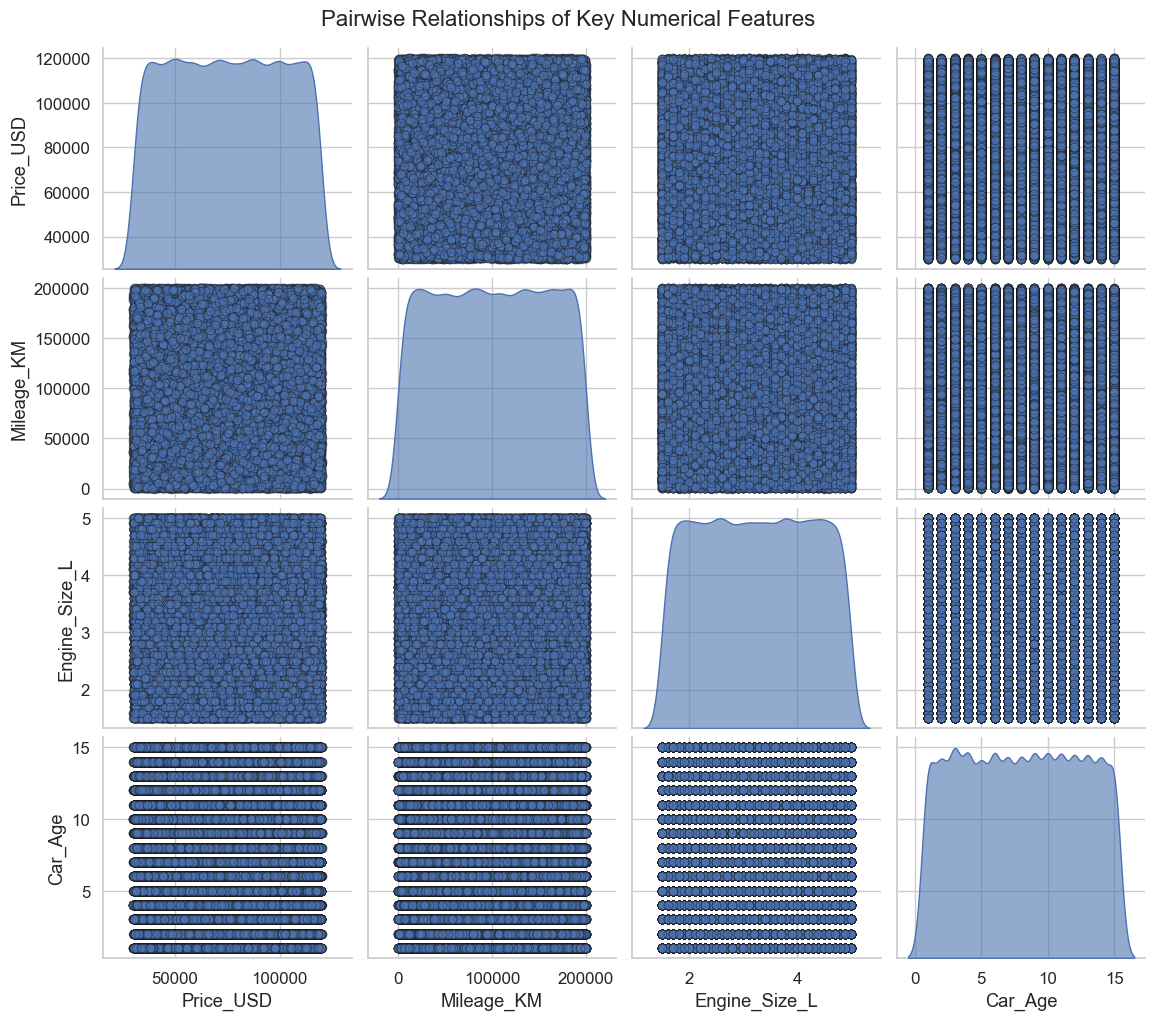

In [24]:
# Pairplot for Key Numerical Features 
# Key numerical features 
num_features = ['Price_USD', 'Mileage_KM', 'Engine_Size_L', 'Car_Age']

# Pairplot
sns.set(style="whitegrid", font_scale=1.1)
pairplot_fig = sns.pairplot(
    df[num_features],
    diag_kind='kde',
    plot_kws={'alpha':0.6, 's':40, 'edgecolor':'k'},
    diag_kws={'shade':True, 'alpha':0.6}
)

pairplot_fig.fig.suptitle("Pairwise Relationships of Key Numerical Features", fontsize=16, y=1.02)
pairplot_fig.fig.set_size_inches(12, 10)
plt.savefig(Path(VISUALS_DIR)/"pairwise_sample.png", dpi=150)
plt.show()


In [25]:
# PCA & RandomForest importance on numeric columns (lightweight)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

features_num = ["Engine_Size_L","Mileage_KM","Sales_Volume","Car_Age"]
X_num = df[features_num].fillna(0)
X_scaled = StandardScaler().fit_transform(X_num)

pca = PCA(n_components=3, random_state=42)
pca.fit(X_scaled)
print("PCA explained variance ratios:", pca.explained_variance_ratio_)

# Quick RF importance (numeric only)
X_rf = pd.DataFrame(X_scaled, columns=features_num)
y_rf = df["Log_Price_USD"].fillna(df["Log_Price_USD"].median())
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_rf, y_rf)
imp = pd.Series(rf.feature_importances_, index=features_num).sort_values(ascending=False)
print("\nNumeric feature importances (RF):\n", imp)


PCA explained variance ratios: [0.2530156  0.25027112 0.24906775]

Numeric feature importances (RF):
 Mileage_KM       0.353764
Sales_Volume     0.343368
Engine_Size_L    0.174624
Car_Age          0.128244
dtype: float64


In [27]:
# Prepare modeling-ready dataset (one-hot encode selected categorical fields)
model_df = df.copy()
cat_cols = ["Region","Model","Fuel_Type","Transmission","Color"]
model_df = pd.get_dummies(model_df, columns=[c for c in cat_cols if c in model_df.columns], drop_first=True)

# Add log columns
for col in ["Price_USD","Sales_Volume"]:
    if ("log_"+col) not in model_df.columns:
        model_df["log_"+col] = model_df[col].apply(lambda x: np.log1p(x) if pd.notnull(x) else 0)

# Save modeling-ready CSV 
processed_path = Path(OUTPUT_DIR) / "bmw_modeling_ready.csv"
model_df.to_csv(processed_path, index=False)
print("Saved modeling-ready CSV:", processed_path)

Saved modeling-ready CSV: ../data/cleaned/bmw_modeling_ready.csv
